In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/train.csv"

data = pd.read_csv(data_path)

# Verificando valores nulos
print(data.isnull().sum())

Mounted at /content/drive
date     0
store    0
item     0
sales    0
dtype: int64


### Funciones y preparación de datos:

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Función para crear secuencias
def create_sequences(data, window_size):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
    return np.array(X)

# Cargar el modelo
model = load_model('/content/drive/MyDrive/my_model.keras')  # Ajusta esto a tu situación


### Genera las predicciones:

In [4]:
window_size = 60
forecast_length = 90  # Para pronosticar 3 meses
results = pd.DataFrame()

# Limitamos el bucle a 2 tiendas, como se solicitó
for store in range(1, 3):
    store_data = data[data['store'] == store]

    # Sumamos las ventas de todos los artículos para la tienda actual
    store_sales = store_data.groupby(['date'])['sales'].sum().reset_index()

    # Usa los últimos datos para hacer las predicciones
    last_sequence = store_sales['sales'].values[-window_size:].reshape(1, window_size, 1)

    # Realizar las predicciones iterativamente y agregar cada predicción a la secuencia para las próximas
    forecasts = []
    for i in range(forecast_length):
        next_point = model.predict(last_sequence)
        forecasts.append(next_point[0][0])
        last_sequence = np.roll(last_sequence, shift=-1)
        last_sequence[0][-1][0] = next_point

    # Agregar las predicciones al dataframe de resultados
    forecast_dates = pd.date_range(start='2018-01-01', periods=forecast_length)
    for j, forecast_date in enumerate(forecast_dates):
        results = results.append({
            'store': store,
            # 'item': item,  # Ya no estamos prediciendo por artículo, así que esta línea no es necesaria
            'date': forecast_date.strftime('%Y-%m-%d'),
            'forecasted_sales': forecasts[j]
        }, ignore_index=True)

print(results)


1/1 [==============================] - 0s 20ms/step


<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-

1/1 [==============================] - 0s 19ms/step
     store        date  forecasted_sales
0        1  2018-01-01          1.112157
1        1  2018-01-02          1.040460
2        1  2018-01-03          1.348611
3        1  2018-01-04          0.926263
4        1  2018-01-05         -0.346255
..     ...         ...               ...
175      2  2018-03-27          0.014098
176      2  2018-03-28          0.014098
177      2  2018-03-29          0.014098
178      2  2018-03-30          0.014098
179      2  2018-03-31          0.014098

[180 rows x 3 columns]


<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-4-de2e9cae889e>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
<ipython-input-

### Visualización:

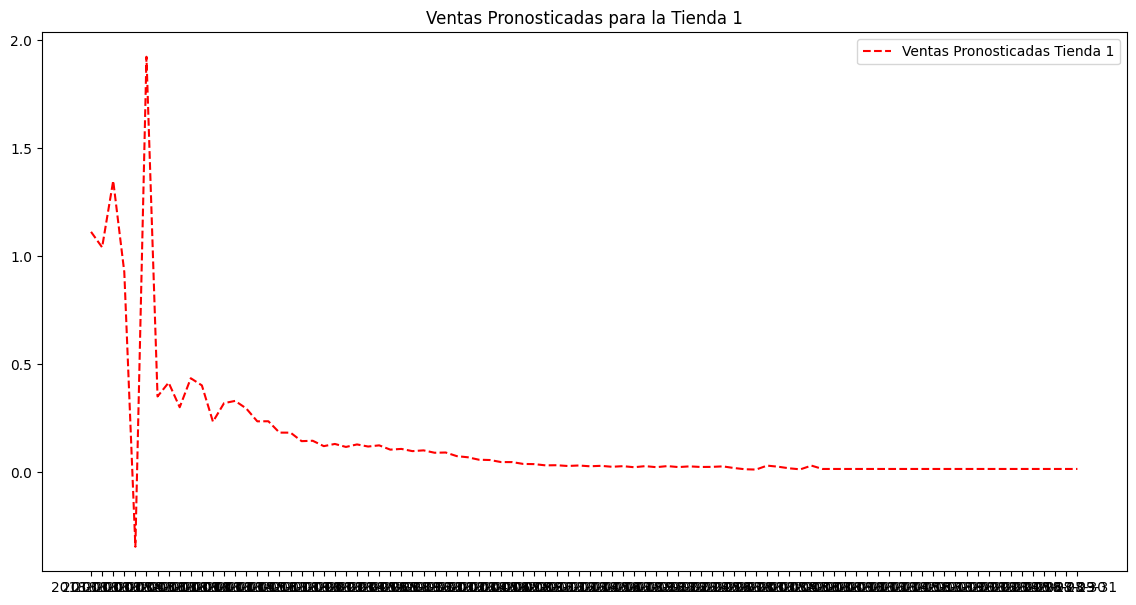

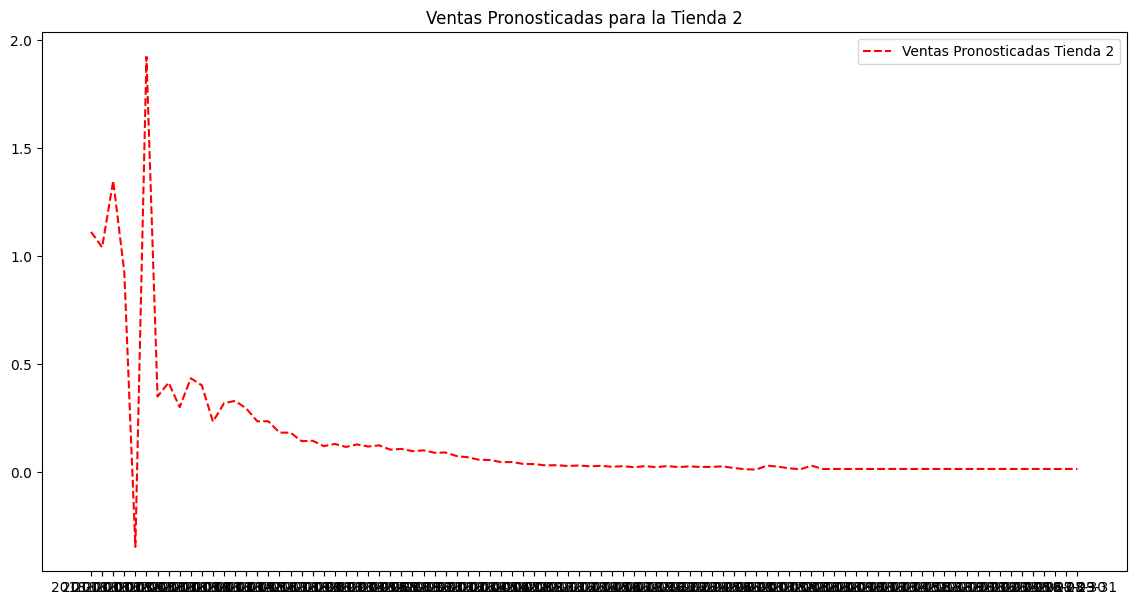

In [10]:
# Antes de combinar, asegúrate de que 'date' en el dataframe 'data' esté en el mismo formato que en 'results'
data['date'] = pd.to_datetime(data['date']).dt.strftime('%Y-%m-%d')

# Ahora, necesitamos sumar las ventas reales de todos los artículos por tienda y fecha, similar a como hicimos para las predicciones
real_sales = data.groupby(['store', 'date'])['sales'].sum().reset_index()

# Combina las ventas reales sumadas con las predicciones; ya que 'item' ya no es un campo en 'results', lo eliminamos del merge
merged = pd.merge(results, real_sales, on=['store', 'date'], how='left')

# Dado que ahora tenemos datos agregados, puede ser útil visualizar los datos por tienda
for store in merged['store'].unique():
    store_data = merged[merged['store'] == store]

    plt.figure(figsize=(14, 7))
    # Omitimos la línea que traza las ventas reales
    plt.plot(store_data['date'], store_data['forecasted_sales'], label=f'Ventas Pronosticadas Tienda {store}', color='red', linestyle='--')
    plt.title(f'Ventas Pronosticadas para la Tienda {store}')
    plt.legend()
    plt.show()